## Clasificación de noticias

En el presente cuaderno realizaremos el proceso completo de clasificación de noticias con modelos RNN y LSTM, abordando desde la exploración de datos y preprocesamiento hasta la implementación de modelos e informe de conclusiones.

**Asignatura:** Procesamiento del lenguaje natural

**Equipo:**

* Germán Alonso Rodríguez Díaz 
* Cristian Baez
* Santiago Simmonds
* David Mariño


In [1]:
# importar las librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec


# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Cargar el archivo de datos
file_path = '../data_raw/Noticias.xlsx'
df_news = pd.read_excel(file_path)

# Mostrar una vista previa de los datos
df_news.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ingen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ingen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Columna1,Enlaces,Título,info,contenido,Etiqueta
0,0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo


In [2]:
# análisis exploratorio de la columna Etiqueta

print(f'Cantidad de etiquetas en la columna Etiqueta: \n')
print(df_news['Etiqueta'].value_counts().head(10))

print('='*50)

print(f'Proporción de etiquetas en la columna Etiqueta: \n')
print(df_news['Etiqueta'].value_counts(normalize=True).head(10))

Cantidad de etiquetas en la columna Etiqueta: 

Etiqueta
archivo     9187
colombia     934
deportes     727
opinion      532
mundo        446
cultura      430
economia     367
justicia     343
bogota       311
vida         268
Name: count, dtype: int64
Proporción de etiquetas en la columna Etiqueta: 

Etiqueta
archivo     0.638163
colombia    0.064879
deportes    0.050500
opinion     0.036955
mundo       0.030981
cultura     0.029869
economia    0.025493
justicia    0.023826
bogota      0.021603
vida        0.018616
Name: proportion, dtype: float64


**Análisis de la columna `Etiqueta`:**
Encontramos que la columna `Etiqueta` tiene un 63% de etiquetas `archivo` del total de noticias y un 6.5% de etiquetas `colombia`.

Las etiquetas de interés para esta actividad: `deportes`, `cultura`, `economia` y `justicia`, suman un 13% del total de noticias.

In [3]:
# filtrar por las categorías de interés

categorias = ['deportes', 'cultura', 'economia', 'justicia']

df_news = df_news[df_news['Etiqueta'].isin(categorias)]

# revisar distribución de las categorías
df_news['Etiqueta'].value_counts()

Etiqueta
deportes    727
cultura     430
economia    367
justicia    343
Name: count, dtype: int64

In [4]:
# equilibrar las categorías

df_news = df_news.groupby('Etiqueta').apply(lambda x: x.sample(340, random_state=42)).reset_index(drop=True)

# revisar distribución de las categorías
df_news['Etiqueta'].value_counts()

C:\Users\ingen\AppData\Local\Temp\ipykernel_11764\2163802621.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_news = df_news.groupby('Etiqueta').apply(lambda x: x.sample(340, random_state=42)).reset_index(drop=True)


Etiqueta
cultura     340
deportes    340
economia    340
justicia    340
Name: count, dtype: int64

In [5]:
df_news.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura


In [6]:
# Preprocesamiento de texto

def clean_text(text):
    # Eliminar caracteres especiales
    text = re.sub(r'\W', ' ', text)
    # Eliminar caracteres de un solo espacio
    text = re.sub(r'\s+', ' ', text)
    # eliminar números
    text = re.sub(r'\d+', '', text)
    # eliminar puntuaación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convertir texto a minúsculas
    text = text.lower()
    return text

# Rellenar valores nulos en la columna 'contenido' con una cadena vacía
df_news['contenido'] = df_news['contenido'].fillna('')

# Aplicar la función de limpieza de texto
df_news['contenido_limpio'] = df_news['contenido'].apply(clean_text)

# revisar los datos
df_news.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta,contenido_limpio
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura,siendo un niño el sol de méxico se convirtió e...
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura,las películas de víctor gaviria constituyen un...
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura,del inagotable repertorio de las salsas no cre...
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura,la casa ubicada en la calle del colegio del c...
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura,judas priest la banda británica fundamental en...


In [7]:
# eliminar stopwords
stop_words = set(stopwords.words('spanish'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Aplicar la función para eliminar stopwords
df_news['contenido_limpio'] = df_news['contenido_limpio'].apply(remove_stopwords)

# revisar los datos
df_news.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta,contenido_limpio
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura,siendo niño sol méxico convirtió auténtico fen...
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura,películas víctor gaviria constituyen capítulo ...
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura,inagotable repertorio salsas creo recordar sup...
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura,casa ubicada calle colegio centro histórico ca...
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura,judas priest banda británica fundamental escen...


In [8]:
# tokenización
df_news['tokens'] = df_news['contenido_limpio'].apply(word_tokenize)

# revisar los datos
df_news.head()


,Columna1,Enlaces,Título,info,contenido,Etiqueta,contenido_limpio,tokens
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura,siendo niño sol méxico convirtió auténtico fen...,"[siendo, niño, sol, méxico, convirtió, auténti..."
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura,películas víctor gaviria constituyen capítulo ...,"[películas, víctor, gaviria, constituyen, capí..."
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura,inagotable repertorio salsas creo recordar sup...,"[inagotable, repertorio, salsas, creo, recorda..."
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura,casa ubicada calle colegio centro histórico ca...,"[casa, ubicada, calle, colegio, centro, histór..."
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura,judas priest banda británica fundamental escen...,"[judas, priest, banda, británica, fundamental,..."


In [9]:
# tokenización y padding con tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Crear un tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_news['contenido_limpio'])

sequences = tokenizer.texts_to_sequences(df_news['contenido_limpio'])
max_len = round(np.quantile([len(i) for i in sequences], 0.75))
pad_sequences = pad_sequences(sequences, maxlen=max_len)

# revisar los datos
print(f'Contenido original: \n{df_news["contenido_limpio"].iloc[0]}')
print(f'Sequence: \n{sequences[0]}')
print(f'Sequence con padding: \n{pad_sequences[0]}')

Contenido original: 
siendo niño sol méxico convirtió auténtico fenómeno méxico pronto arrasó toda latinoamérica marcando generaciones enteras estrella luego años bache carrera regresó popularidad gracias serie basada vida empezó cantar apenas diez años pronto convirtió fenómeno méxico grandes voces canción romántica así aún cumplido quince años recibió primer grammy canción gustas tal interpretó dúo escocesa sheena easton hoy tras cuatro décadas carrera sigue siendo grandes representantes música mexicana latina mundo temprano luis miguel deja ser niño ser trabajador sometido disciplina tenaz claro marcado vida completamente aspectos positivos desarrollar carrera sólida negativos haberse visto privado momentos haberse fracturado carrera asegura periodista javier león herrera personas quizás conozca vida artista escrito varias biografías puede interesar rené cara íntima residente luis miguel nació veracruz hizo creer padre inicio carrera sino san juan puerto rico impedimento rápidamente

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# codificar las etiquetas con label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_news['target'] = label_encoder.fit_transform(df_news['Etiqueta'])
df_news['target'] = df_news['target'].astype('float32')



# dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(pad_sequences, 
                                                  df_news['target'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# revisar las dimensiones de los datos
print(f'Dimensiones de los datos de entrenamiento: \n')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')


Dimensiones de los datos de entrenamiento: 

X_train: (1088, 413)
y_train: (1088,)
X_val: (272, 413)
y_val: (272,)


In [11]:
df_news['target'].value_counts()

target
0.0    340
1.0    340
2.0    340
3.0    340
Name: count, dtype: int64

In [12]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Columna1          1360 non-null   int64  
 1   Enlaces           1360 non-null   object 
 2   Título            1360 non-null   object 
 3   info              1325 non-null   object 
 4   contenido         1360 non-null   object 
 5   Etiqueta          1360 non-null   object 
 6   contenido_limpio  1360 non-null   object 
 7   tokens            1360 non-null   object 
 8   target            1360 non-null   float32
dtypes: float32(1), int64(1), object(7)
memory usage: 90.4+ KB


In [76]:
# crear modelo de RNN simple
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout, Bidirectional

Epoch 1/250


c:\Users\ingen\Documents\estudio\especializacion_ml\ml\nlp\nlp_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.2611 - loss: 3.1296 - val_accuracy: 0.2684 - val_loss: 3.0432
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.2690 - loss: 3.0664 - val_accuracy: 0.3493 - val_loss: 2.9479
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.3634 - loss: 2.8985 - val_accuracy: 0.4706 - val_loss: 2.7214
Epoch 4/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.4615 - loss: 2.7109 - val_accuracy: 0.5037 - val_loss: 2.6160
Epoch 5/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5508 - loss: 2.5144 - val_accuracy: 0.4890 - val_loss: 2.5906
Epoch 6/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5791 - loss: 2.3609 - val_accuracy: 0.5625 - val_loss: 2.3183
Epoch 7/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.6674 - loss: 2.1960 - val_accuracy: 0.5919 - val_loss: 2.3462
Epoch 8/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.7469 - loss: 2.0683 - val_accuracy: 0.680

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_54 (Embedding)        │ (32, 413, 128)         │     5,393,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_58 (SimpleRNN)       │ (32, 413, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (32, 413, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,577,293 (63.24 MB)

 Trainable params: 5,525,764 (21.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,051,529 (42.16 MB)

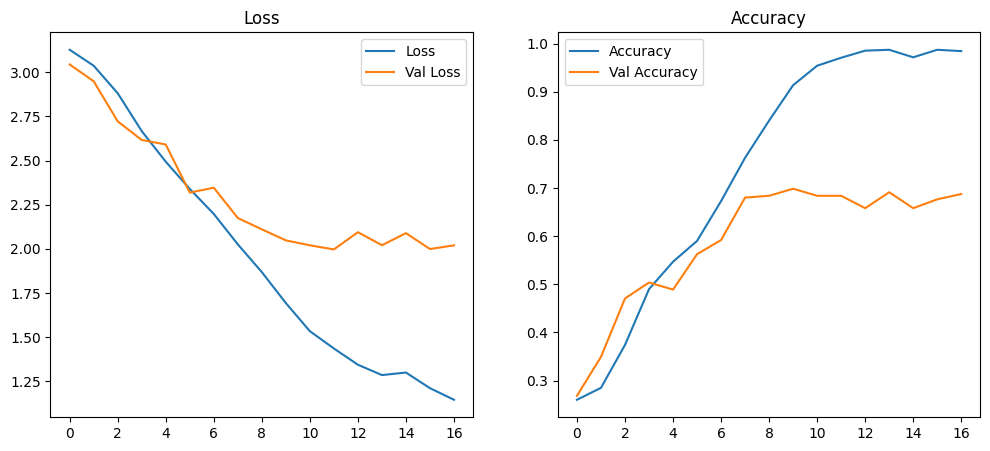

In [88]:
# Definir la dimensión de los embeddings
embedding_dim = 128

# Crear el modelo
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=embedding_dim, 
                    input_length=pad_sequences.shape[1]))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(Bidirectional(SimpleRNN(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

# configurar early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5, 
                                                  restore_best_weights=True,
                                                  verbose=1,
                                                  min_delta=0.01)

# Compilar el modelo

# Decaimiento exponencial
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.8
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])


# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    epochs=250, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Resumen del modelo
model.summary()

# Visualizar la pérdida y la precisión del modelo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
# guardar el modelo

# model.save('./models/rnn_model.keras')

In [93]:
# usar modelo para predecir

# cargar el modelo

# model = tf.keras.models.load_model('./models/rnn_model.keras')

# predecir
y_pred = model.predict(X_val)

# convertir las predicciones a etiquetas
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val

# evaluar el modelo
from sklearn.metrics import classification_report

print(classification_report(y_val_labels, y_pred_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
              precision    recall  f1-score   support

         0.0       0.56      0.75      0.64        65
         1.0       0.72      0.70      0.71        73
         2.0       0.73      0.61      0.67        62
         3.0       0.77      0.67      0.72        72

    accuracy                           0.68       272
   macro avg       0.70      0.68      0.68       272
weighted avg       0.70      0.68      0.69       272



In [94]:
# predecir noticias nuevas

noticias_nuevas = ['el dolar, la economía y la inflación afectan los bolsillos de los ciudadanos, mientras que el gobierno busca soluciones',]

# limpiar y tokenizar las noticias

noticias_nuevas_limpio = [clean_text(noticia) for noticia in noticias_nuevas]
noticias_nuevas_limpio = [remove_stopwords(noticia) for noticia in noticias_nuevas_limpio]
noticias_nuevas_tokens = [word_tokenize(noticia) for noticia in noticias_nuevas_limpio]

# convertir las noticias a secuencias
noticias_nuevas_sequences = tokenizer.texts_to_sequences(noticias_nuevas_limpio)
noticias_nuevas_pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(noticias_nuevas_sequences, maxlen=max_len)

# predecir
y_pred_nuevas = model.predict(noticias_nuevas_pad_sequences)
y_pred_labels_nuevas = np.argmax(y_pred_nuevas, axis=1)

# convertir las etiquetas a categorías
categorias = label_encoder.inverse_transform(y_pred_labels_nuevas)

# mostrar resultados
resultados = pd.DataFrame({'Noticia': noticias_nuevas, 'Categoría': categorias})
print(resultados)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
                                             Noticia Categoría
0  el dolar, la economía y la inflación afectan l...  deportes


In [95]:
# imprimir categorias y etiquetas

categorias = label_encoder.classes_
etiquetas = label_encoder.transform(categorias)

print(f'Categorías: {categorias}')
print(f'Etiquetas: {etiquetas}')

Categorías: ['cultura' 'deportes' 'economia' 'justicia']
Etiquetas: [0 1 2 3]


In [127]:
# Validemos el modelo con la base de testeo

loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.9971
Test Accuracy: 0.6838


Epoch 1/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2461 - loss: 18.1060 - val_accuracy: 0.3051 - val_loss: 17.0992
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2308 - loss: 16.7812 - val_accuracy: 0.3162 - val_loss: 15.8476
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2543 - loss: 15.5538 - val_accuracy: 0.3125 - val_loss: 14.6909
Epoch 4/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2402 - loss: 14.4201 - val_accuracy: 0.2868 - val_loss: 13.6214
Epoch 5/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3008 - loss: 13.3702 - val_accuracy: 0.2868 - val_loss: 12.6314
Epoch 6/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3073 - loss: 12.3975 - val_accuracy: 0.2831 - val_loss: 11.7150
Epoch 7/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.3110 - loss: 11.5010 - val_accuracy: 0.2831 - val_loss: 10.8677
Epoch 8/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2976 - loss: 10.6703 - val_accur

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_80 (Embedding)        │ (32, 413, 128)         │     5,393,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (32, 413, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (32, 413, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (32, 256)              │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,465,485 (66.63 MB)

 Trainable params: 5,821,828 (22.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,643,657 (44.42 MB)

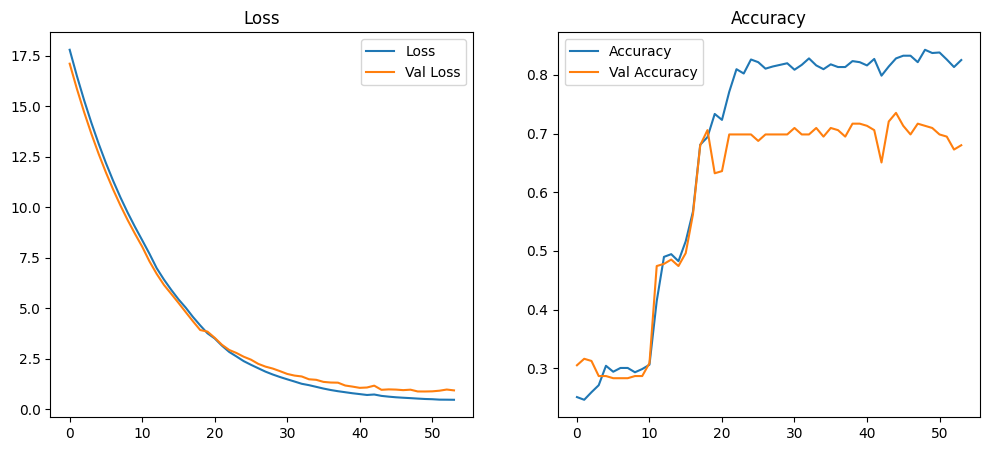

In [121]:
# crear modelo de LSTM

# Crear el modelo
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=embedding_dim, 
                    input_length=pad_sequences.shape[1]))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.4))
model_lstm.add(Bidirectional(LSTM(128)))
model_lstm.add(Dropout(0.4))
# model_lstm.add(LSTM(128))
# model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(4, activation='softmax'))

# configurar early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5, 
                                                  restore_best_weights=True,
                                                  verbose=1,
                                                  min_delta=0.01)

# Compilar el modelo

# Decaimiento exponencial
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Compilar el modelo
model_lstm.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])

# Entrenar el modelo
history_lstm = model_lstm.fit(X_train, y_train, 
                    epochs=250, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Resumen del modelo
model_lstm.summary()

# Visualizar la pérdida y la precisión del modelo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [122]:
# obtener los mejores parámetros del entrenamiento

best_epoch = np.argmax(history_lstm.history['val_accuracy']) + 1
best_val_acc = np.max(history_lstm.history['val_accuracy'])
best_val_loss = np.min(history_lstm.history['val_loss'])

print(f'Best epoch: {best_epoch}')
print(f'Best val_acc: {best_val_acc}')
print(f'Best val_loss: {best_val_loss}')

Best epoch: 45
Best val_acc: 0.7352941036224365
Best val_loss: 0.882672905921936


In [123]:
# obtener los mejore hipérparametros

best_params = model_lstm.get_config()
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'name': 'sequential_80', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (32, 413), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_78'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding_80', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 42138, 'output_dim': 128, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': (32, 413)}}, {'mo

In [ ]:
# guardar el modelo

# model_lstm.save('./models/lstm_model.keras')

In [125]:
# predecir noticias nuevas

noticias_nuevas = ['el dolar, la economía y la inflación afectan los bolsillos de los ciudadanos, mientras que el gobierno busca soluciones',]

# limpiar y tokenizar las noticias

noticias_nuevas_limpio = [clean_text(noticia) for noticia in noticias_nuevas]
noticias_nuevas_limpio = [remove_stopwords(noticia) for noticia in noticias_nuevas_limpio]
noticias_nuevas_tokens = [word_tokenize(noticia) for noticia in noticias_nuevas_limpio]

# convertir las noticias a secuencias
noticias_nuevas_sequences = tokenizer.texts_to_sequences(noticias_nuevas_limpio)
noticias_nuevas_pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(noticias_nuevas_sequences, maxlen=max_len)

# predecir
y_pred_nuevas = model_lstm.predict(noticias_nuevas_pad_sequences)
y_pred_labels_nuevas = np.argmax(y_pred_nuevas, axis=1)

# convertir las etiquetas a categorías
categorias = label_encoder.inverse_transform(y_pred_labels_nuevas)

# mostrar resultados
resultados = pd.DataFrame({'Noticia': noticias_nuevas, 'Categoría': categorias})
print(resultados)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
                                             Noticia Categoría
0  el dolar, la economía y la inflación afectan l...  deportes


In [126]:
# Validemos el modelo con la base de testeo

loss, accuracy = model_lstm.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.8843
Test Accuracy: 0.7132


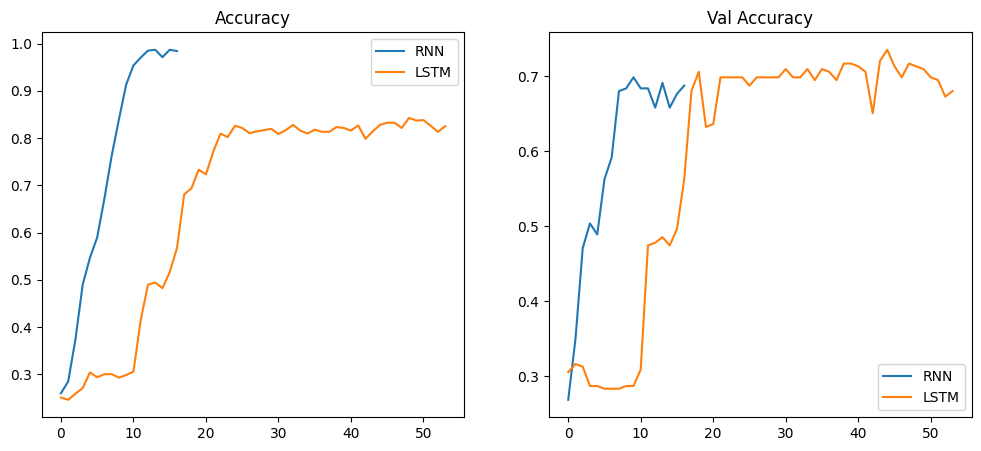

In [128]:
# grafico comparativo de los resultados de los modelos RNN y LSTM

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='RNN')
plt.plot(history_lstm.history['accuracy'], label='LSTM')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='RNN')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.title('Val Accuracy')
plt.legend()

plt.show()